In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from ewald import *
from core import *
from pic3d3v import *
from interp import *
from solvers import *
norm = lambda x: np.max(np.abs(x))

In [3]:
N = 100
alpha = 1.
Lz = Ly = Lx = 2*np.pi

rmax = 1.
#beta_vals = np.linspace(.25, 1.25, 20)
beta_vals = np.linspace(1.5, 4., 20)
nz = ny = nx = 64

In [4]:
np.random.seed(9998)
zp = np.random.rand(N)*Lz
yp = np.random.rand(N)*Ly
xp = np.random.rand(N)*Lx
q  = np.ones(N, dtype=np.double)
particles = Species(N, 1., 1., x0=xp, y0=yp, z0=zp)

In [5]:
res  = []
mmax_vals = range(5, 10+1)
for mmax in range(5, 10+1):
    
    Ezp, Eyp, Exp = ewald_sum(zp, Lz, yp, Ly, xp, Lx, 
                              q, alpha, mmax, mmax)
    
    res.append((Ezp, Eyp, Exp))

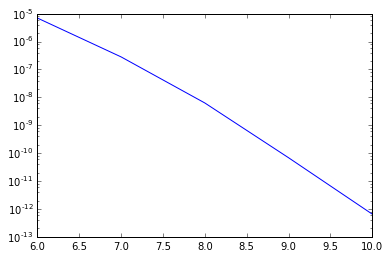

In [6]:
max_change = []
for r1, r2 in zip(res[:-1], res[1:]):
    max_change.append(np.max([np.max(np.abs(r1[i]-r2[i])) 
                              for i in range(3)]))
plt.semilogy(mmax_vals[1:], max_change)       

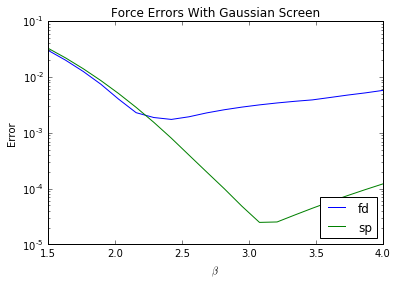

In [7]:
particle_shape = 5
p1 = particle_shape
errs_fd = []
errs_sp = []
for beta in beta_vals:
    
    picp3m = PIC3DP3M([particles], (Lz,Ly,Lx), (nz,ny,nx))
    picp3m.init_run(0, beta=beta, rmax=rmax, N_cells=1,
                    solver_opts={"diff_type":"fd"},
                    particle_shape=particle_shape)
    Ezp3m, Eyp3m, Exp3m = picp3m.calc_E_at_points()

    errs_fd.append(np.max([norm(Ezp3m-Ezp), 
                           norm(Eyp3m-Eyp), 
                           norm(Exp3m-Exp)]))
    
    picp3m = PIC3DP3M([particles], (Lz,Ly,Lx), (nz,ny,nx))
    picp3m.init_run(0, beta=beta, rmax=rmax, N_cells=1,
                    solver_opts={"diff_type":"spectral"},
                    particle_shape=particle_shape)
    Ezp3m, Eyp3m, Exp3m = picp3m.calc_E_at_points()

    errs_sp.append(norm(np.sqrt((Ezp3m-Ezp)**2+\
                                (Eyp3m-Eyp)**2+\
                                (Exp3m-Exp)**2)))
    
errs_fd_b3 = errs_fd
errs_sp_b3 = errs_sp
plt.semilogy(beta_vals, errs_fd, label="fd")
plt.semilogy(beta_vals, errs_sp, label="sp")
plt.legend(loc='lower right')
plt.xlabel("$\\beta$")
plt.ylabel("Error")
plt.title("Force Errors With Gaussian Screen")
#plt.savefig("fe-gaussian.pdf")

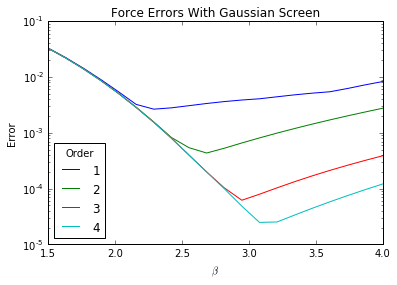

In [8]:
particle_shapes = range(2, 5+1)
p2 = particle_shape
errs_shapes = [[] for _ in particle_shapes]

for beta in beta_vals:
    i = 0
    for particle_shape in particle_shapes:
        picp3m = PIC3DP3M([particles], (Lz,Ly,Lx), (nz,ny,nx))
        picp3m.init_run(0, beta=beta, rmax=rmax, N_cells=1,
                        solver_opts={"diff_type":"spectral"},
                        particle_shape=particle_shape)
        Ezp3m, Eyp3m, Exp3m = picp3m.calc_E_at_points()

        errs_shapes[i].append(norm(np.sqrt((Ezp3m-Ezp)**2+\
                                           (Eyp3m-Eyp)**2+\
                                           (Exp3m-Exp)**2)))
    
        i += 1

for i in range(len(particle_shapes)):
    plt.semilogy(beta_vals, errs_shapes[i], 
                 label=str(particle_shapes[i]-1))
    
plt.legend(loc='lower left', title="Order")
plt.xlabel("$\\beta$")
plt.ylabel("Error")
plt.title("Force Errors With Gaussian Screen")
plt.savefig("force-errors-combined.pdf")

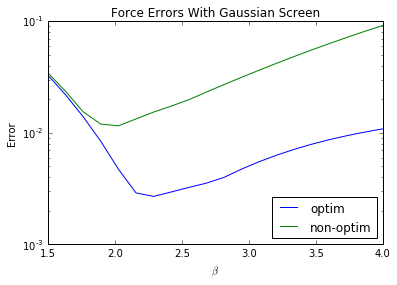

In [9]:
particle_shape = 2

errs_optim = []
errs_non_optim = []
for beta in beta_vals:
    
    picp3m = PIC3DP3M([particles], (Lz,Ly,Lx), (nz,ny,nx))
    picp3m.init_run(0, beta=beta, rmax=rmax, N_cells=1,
                    solver_opts={"diff_type":"fd",
                                 "screen":(GaussianScreen,
                                           {"optimized":False})},
                    particle_shape=particle_shape)
    Ezp3m, Eyp3m, Exp3m = picp3m.calc_E_at_points()

    errs_non_optim.append(norm(np.sqrt((Ezp3m-Ezp)**2+\
                                       (Eyp3m-Eyp)**2+\
                                       (Exp3m-Exp)**2)))
    
    picp3m = PIC3DP3M([particles], (Lz,Ly,Lx), (nz,ny,nx))
    picp3m.init_run(0, beta=beta, rmax=rmax, N_cells=1,
                    solver_opts={"diff_type":"fd"},
                    particle_shape=particle_shape)
    Ezp3m, Eyp3m, Exp3m = picp3m.calc_E_at_points()

    errs_optim.append(norm(np.sqrt((Ezp3m-Ezp)**2+\
                                   (Eyp3m-Eyp)**2+\
                                   (Exp3m-Exp)**2)))
    
plt.semilogy(beta_vals, errs_optim, label="optim")
plt.semilogy(beta_vals, errs_non_optim, label="non-optim")
plt.legend(loc='lower right')
plt.xlabel("$\\beta$")
plt.ylabel("Error")
plt.title("Force Errors With Gaussian Screen")
plt.savefig("optim-errs.pdf")

In [10]:
#rmax = 4.
#beta_vals = np.linspace(.8, 1.5, 20)
#nz = ny = nx = 64
#particles = Species(N, 1., 1., x0=xp, y0=yp, z0=zp)

#errs = []
#for beta in []:#beta_vals:
#    picp3m = PIC3DP3M([particles], (Lz,Ly,Lx), (nz,ny,nx))
#    picp3m.init_run(0, beta=beta, rmax=rmax, N_cells=1, screen=S2Screen)
#    Ezp3m, Eyp3m, Exp3m = picp3m.calc_E_at_points()

#    errs.append(np.max([norm(Ezp3m-Ezp), norm(Eyp3m-Eyp), norm(Exp3m-Exp)]))
    
#plt.semilogy(beta_vals, errs)
#plt.xlabel("$\\beta$")
#plt.ylabel("Error")
#plt.title("Force Errors With HE Screen")
#plt.savefig("fe-he.pdf")